### Setting up the virtual environment
This part is for Google Colab, omit it if you already have a properly set up environment.

In [51]:
!pip install PyPortfolioOpt
!pip install qiskit==1.4.2
!pip install qiskit_optimization
!pip install qiskit_algorithms

### Imports
We begin by importing the necessary packages. Pay attention to the last two imports, `quantum_subroutine` and `asset_screening`. You can view these modules in more detail in their respective .py files in the repository.

The `quantum_subroutine` module takes care of the data preprocessing, postprocessing, and the implementation of the recursive quantum max-cut.

The `asset_screening` module takes care of mitigating the risk-based asset selection performed by the quantum subroutine by aggressively selecting the best performing stocks from the subgroups returned by the quantum subroutine.


This might sound somewhat confusing for the time being, but it is explained in more detail below.

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pypfopt
import quantum_subroutine as j
import asset_screening as s

### Loading the data and preprocessing
We begin by importing and loading the data using the `data_loader` function from the `quantum_subroutine` module. We then preprocess. To view the preprocessing in more detail, please refer to the `quantum_subroutine` module.

In [53]:
input_file_name = "/content/input.json"

# Load the data (assets is an object required for further processing)
df, assets = j.data_loader(input_file_name)

# We take the entire dataset into consideration in this run.
# This can be tweaked by changing the following two bounds:
start_date = df.index.min()
end_date = df.index.max()

# We obtain the maximally connected graph using the `preprocessing` function
# from the jimmy module.
G = j.preprocessing(df, assets, start_date, end_date)

### Quantum Subroutine
We proceed by invoking the quantum subroutine.

In order to understand how it works and what value

In [54]:
B = j.recursive_maxcut_partition(G, depth=1, level=0, path="0")

Now we have the 4 subdivided graphs in the `B` list (two subgraphs per level of subdivision). We visualize them to see what they look like in the following cell:

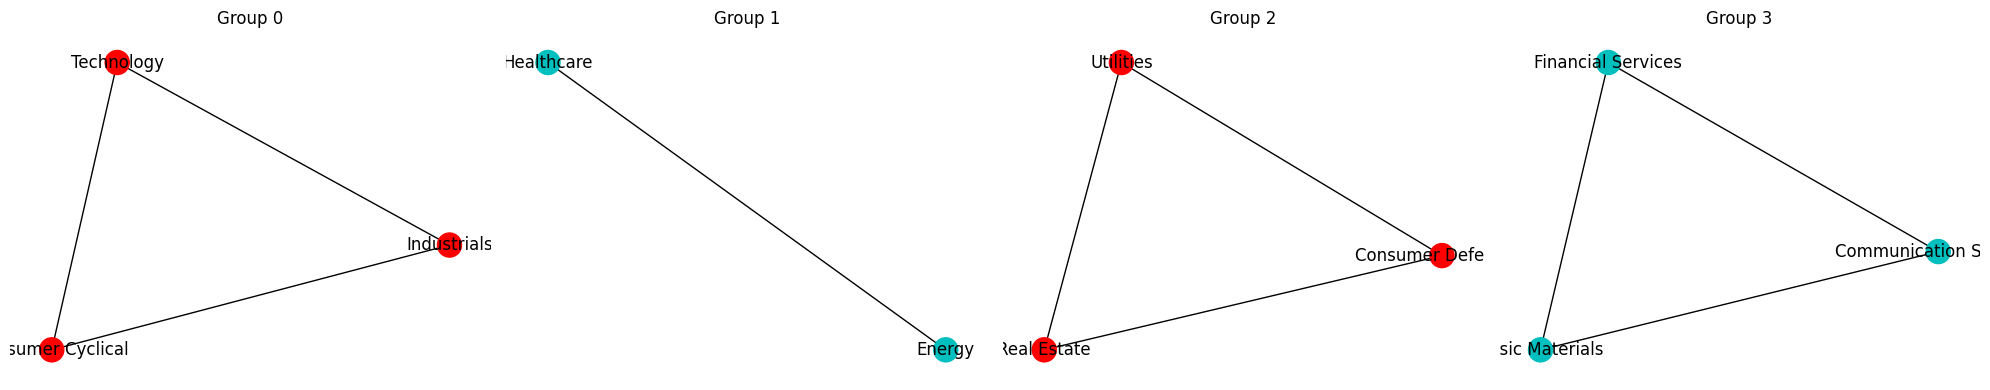

In [55]:
def draw_partitioned_graphs(graphs, partitions, positions, titles=None):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5 * len(graphs), 4))
    if len(graphs) == 1:
        axs = [axs]
    for i, (G, part, pos) in enumerate(zip(graphs, partitions, positions)):
        colors = ['r' if part[node] == 0 else 'c' for node in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=colors, ax=axs[i])
        title = titles[i] if titles else f"Partition {i}"
        axs[i].set_title(title)
    plt.tight_layout()
    plt.show()

# B is a flat list of subgraphs from recursive_maxcut_partition with depth=1
# That means B = [G00, G01, G10, G11] if top-level split gave G0 and G1, each further split

positions = [nx.spring_layout(graph, seed=42) for graph in B]
partitions = [{n: i % 2 for n in graph.nodes()} for i, graph in enumerate(B)]  # alternate colors

draw_partitioned_graphs(B, partitions, positions, titles=[f"Group {i}" for i in range(len(B))])

Before proceeding further, we must postprocess the output of the quantum subroutine by taking only the tickers for the assets within each of the subgroups:

In [56]:
asset_lists = [[] for _ in range(len(B))]  # Initializing an empty list with 4 empty lists inside

for i, graph in enumerate(B):
    sectors_in_graph = list(graph.nodes)
    for asset, data in assets.items():
        if data.get('sector') in sectors_in_graph:
            asset_lists[i].append(asset)  # Adding the asset to the corresponding list within asset_lists

# Visualization of the results:
for i, asset_list in enumerate(asset_lists):
    print(f"Subgraph {i}: {asset_list}")

print(asset_lists)

Subgraph 0: ['AAL', 'AAON', 'AAPL', 'ABNB', 'ACIW', 'ACLS', 'ACMR', 'ADBE', 'ADEA', 'ADI', 'ADP', 'ADSK', 'ADTN', 'AEIS', 'AEVA', 'AFRM', 'AGYS', 'AKAM', 'ALGM', 'ALGT', 'ALKT', 'ALNT', 'ALRM', 'AMAT', 'AMBA', 'AMD', 'AMKR', 'AMPL', 'AMSC', 'AMWD', 'AMZN', 'ANSS', 'AOSL', 'APLD', 'APOG', 'APP', 'APPF', 'APPN', 'APPS', 'ARCB', 'ARHS', 'ARKO', 'ARRY', 'ASLE', 'ASO', 'ASTE', 'ASTS', 'ATRO', 'AUR', 'AVAV', 'AVDX', 'AVGO', 'AVPT', 'AVT', 'AXON', 'BAND', 'BASE', 'BBCP', 'BBSI', 'BELFB', 'BIGC', 'BJRI', 'BKNG', 'BL', 'BLBD', 'BLDP', 'BLKB', 'BLMN', 'BRZE', 'BSY', 'BWMN', 'CAKE', 'CAR', 'CARG', 'CASS', 'CASY', 'CBRL', 'CCCS', 'CCSI', 'CDNS', 'CDW', 'CECO', 'CEVA', 'CFLT', 'CGNX', 'CHDN', 'CHRW', 'CLFD', 'CLMB', 'CMCO', 'CMPO', 'CMPR', 'CNDT', 'CNXC', 'CNXN', 'COHU', 'COLM', 'COMM', 'CPRT', 'CRAI', 'CRCT', 'CRDO', 'CRMT', 'CRNC', 'CROX', 'CRSR', 'CRUS', 'CRWD', 'CSCO', 'CSGS', 'CSX', 'CTAS', 'CTLP', 'CTSH', 'CVCO', 'CVLT', 'CWST', 'CZR', 'DAKT', 'DBX', 'DCBO', 'DDOG', 'DGII', 'DIOD', 'DJCO', 'D

### Sortino Choosing
Now we select the best 10 in every subgraph based on the Sortino ratio.This yields a portfolio of 40 assets (this is easily changeable, we used 40 here as we had good results with it, in the real world more would probably be required). We use the Sortino ratio due to its relative aggressiveness in order to mitigate the quantum subroutine which encodes risk into the model.

In [57]:
top_assets_all = []

for subgraph in asset_lists:
    df_subgraph = df[subgraph]

    # Drop columns with all NaNs (to avoid issues)
    df_subgraph = df_subgraph.dropna(axis=1, how='all')

    if df_subgraph.empty:
        continue  # skip if no valid data

    # Compute daily returns
    returns_df = pypfopt.expected_returns.returns_from_prices(df_subgraph)

    if returns_df.empty or returns_df.shape[1] == 0:
        continue

    # Compute Sortino ratios
    ratios = s.calculate_sortino_ratio(returns_df)

    # Sort and get top 10 assets in this subgraph
    top_10 = ratios.sort_values(ascending=False).head(10).index.tolist()

    top_assets_all.extend(top_10)

# Final result: list of top assets across all subgraphs (10 per group)
print(f"Selected {len(top_assets_all)} assets.")
print(top_assets_all)

Selected 40 assets.
['FER', 'LIF', 'LMB', 'AXON', 'PLTR', 'IDCC', 'POWL', 'IESC', 'STRL', 'MSTR', 'SLNO', 'INDV', 'SMMT', 'ADMA', 'SRRK', 'MDGL', 'RYTM', 'INSM', 'BBIO', 'NTRA', 'SFM', 'PRDO', 'CEG', 'CCEP', 'LINC', 'COST', 'LOPE', 'LAUR', 'COCO', 'COKE', 'NFLX', 'SKWD', 'USLM', 'HWKN', 'ROOT', 'COOP', 'VEON', 'TMUS', 'PPTA', 'ACGL']


### Classical Weight Optimization

In [58]:
df_selected = df[top_assets_all]
df_selected.head()

,FER,LIF,LMB,AXON,PLTR,IDCC,POWL,IESC,STRL,MSTR,...,NFLX,SKWD,USLM,HWKN,ROOT,COOP,VEON,TMUS,PPTA,ACGL
2022-05-09,22.970497,NaN,5.88,87.889999,7.46,56.213924,23.385435,26.879999,22.459999,21.905001,...,173.100006,NaN,21.199301,35.734524,26.459999,43.250000,12.25,119.041023,3.30,42.999634
2022-05-10,22.970497,NaN,6.00,89.459999,7.29,56.090561,24.531496,28.270000,22.000000,22.552000,...,177.660004,NaN,20.735178,35.182068,24.299999,42.040001,12.25,120.282974,3.32,43.541645
2022-05-11,23.245127,NaN,5.54,84.370003,6.71,55.549686,24.181051,29.160000,22.110001,16.820000,...,166.369995,NaN,20.816154,34.959156,21.780001,41.169998,12.00,120.556786,3.22,43.484589
2022-05-12,23.245127,NaN,5.75,87.040001,7.34,55.635094,24.683046,29.160000,22.969999,17.118000,...,174.309998,NaN,21.683165,35.220844,22.139999,40.439999,11.25,121.290207,3.21,43.018650
2022-05-13,23.245127,NaN,5.78,98.220001,8.34,56.602985,24.086332,29.330000,22.930000,20.457001,...,187.639999,NaN,22.198631,35.850822,24.480000,42.790001,11.75,123.539406,3.08,43.760349


In [59]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df_selected)
S = CovarianceShrinkage(df_selected).ledoit_wolf()

In [60]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S, verbose=True, solver="ECOS") # we use the ECOS solver to deal with the size and complexity of the data.
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
w = ef.max_sharpe()
print(ef.clean_weights())

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 08:32:36 AM: Your problem has 41 variables, 83 constraints, and 0 parameters.
(CVXPY) May 11 08:32:36 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 08:32:36 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 08:32:36 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 08:32:36 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 08:32:36 AM: Compiling problem (target solver=ECOS).
(CV

/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [61]:
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('FER', 0.00497), ('LIF', 0.0245), ('LMB', 0.05767), ('AXON', 0.03042), ('PLTR', 0.0481), ('IDCC', 0.01881), ('POWL', 0.03303), ('IESC', 0.03538), ('STRL', 0.03204), ('MSTR', 0.05204), ('SLNO', 0.05761), ('INDV', 0.01104), ('SMMT', 0.05328), ('ADMA', 0.04944), ('SRRK', 0.01946), ('MDGL', 0.0199), ('RYTM', 0.05266), ('INSM', 0.01805), ('BBIO', 0.02715), ('NTRA', 0.02345), ('SFM', 0.03095), ('PRDO', 0.01528), ('CEG', 0.02292), ('CCEP', 0.00892), ('LINC', 0.01404), ('COST', 0.00915), ('LOPE', 0.00836), ('LAUR', 0.01087), ('COCO', 0.01535), ('COKE', 0.01158), ('NFLX', 0.02941), ('SKWD', 0.02166), ('USLM', 0.02221), ('HWKN', 0.01619), ('ROOT', 0.02209), ('COOP', 0.01267), ('VEON', 0.01873), ('TMUS', 0.00973), ('PPTA', 0.02099), ('ACGL', 0.00989)])


Thus, we have the optimized weights in the OrderedDict.

In [62]:
ef.portfolio_performance(verbose=True)

Expected annual return: 107.6%
Annual volatility: 26.5%
Sharpe Ratio: 4.07


(np.float64(1.0758885960795144),
 np.float64(0.2646185544141871),
 np.float64(4.065809362693096))

### TESTING

In [63]:
import copy
import pandas as pd
def super_run(input_data,solver_params,extra_arguments,portfolio):
    from_=input_data['from']
    to_=input_data['to']
    assets=input_data['assets']
    dfs=[]
    for asset in assets:
        dfs.append(pd.Series(assets[asset]['history'],name=asset))
    df=pd.concat(dfs,axis=1).bfill().pct_change()
    ini=1
    results={}
    results[max([x for x in df.index.tolist() if x<from_])]=ini
    for t in [ x for x in df.index.tolist() if x>=from_ and x<=to_]:
        d={}
        d['num_assets']=input_data['num_assets']
        assets_=copy.deepcopy(assets)
        for asset in assets_:
            assets_[asset]['history']={x:assets_[asset]['history'][x] for x in assets_[asset]['history'] if x<t}
        d['assets']=assets_
        d['evaluation_date']=t
        r=portfolio
        gain=0
        for asset in r:
            gain=gain+(df[asset][t]*r[asset])
        ini=ini*(1+gain)
        results[t]=ini
    res={}
    res['results']=results
    res['final_result']=ini
    return res

In [64]:
with open(input_file_name) as f:
  input_data = json.load(f)

data = input_data["data"]

# Optional extra parameters
if "extra_arguments" in input_data:
    extra_arguments = input_data['extra_arguments']
else:
    extra_arguments = {}

if "solver_params" in input_data:
    solver_params = input_data['solver_params']
else:
    solver_params = {}


input_data['from'] = "2024-07-01"
input_data['to'] = "2024-08-30"

super_run(data,solver_params,extra_arguments,cleaned_weights)

{'results': {'2025-03-31': 1,
  '2025-04-01': np.float64(0.9991665312245588),
  '2025-04-02': np.float64(1.0312119906527468),
  '2025-04-03': np.float64(0.9862612247919382),
  '2025-04-04': np.float64(0.9295769274691055),
  '2025-04-07': np.float64(0.9424671198111471),
  '2025-04-08': np.float64(0.9220652012578461),
  '2025-04-09': np.float64(1.0187989354838354),
  '2025-04-10': np.float64(0.9971914779166392),
  '2025-04-11': np.float64(1.0324428835873856),
  '2025-04-14': np.float64(1.0659951628358895),
  '2025-04-15': np.float64(1.0753945081985363),
  '2025-04-16': np.float64(1.0631396316155561),
  '2025-04-17': np.float64(1.0714644502811637),
  '2025-04-21': np.float64(1.0379010439113545),
  '2025-04-22': np.float64(1.080658410780822),
  '2025-04-23': np.float64(1.1180159887099352),
  '2025-04-24': np.float64(1.1556642492006957),
  '2025-04-25': np.float64(1.139883224924204),
  '2025-04-28': np.float64(1.150502426153942),
  '2025-04-29': np.float64(1.162129856093734),
  '2025-04-30'